In [1]:
import os
import pandas as pd
import numpy as np
from datetime import date, timedelta
import matplotlib.pyplot as plt

In [63]:
def readPayments(file_name, date_header="PaymentDate"):
    dataLoc = os.path.join(current_wd, "..", "data", file_name)
    paymentsData = pd.read_csv(dataLoc)
    paymentsData[date_header] = pd.to_datetime(paymentsData[date_header])
    
    return paymentsData

def calcTaxPA(grossSalaryPA):
    '''calculates tax paid per year based on 
    UK tax bands'''
    taxFreeAllowance = 12500
    if grossSalaryPA <= taxFreeAllowance:
        taxPA = 0
    elif grossSalaryPA <= 50000:
        taxPA = 0.2*(grossSalaryPA - 12500)
    elif grossSalaryPA > 50000 and grossSalaryPA <= 150000:
        taxPA = (0.4*(grossSalaryPA - 50000)) + (0.2*(50000 - 12500))
    elif grossSalaryPA > 150000:
        taxPA = (0.45*(grossSalaryPA - 150000)) + (0.4*(150000 - 50000)) + (0.2*(50000 - 12500))
    return taxPA


def calcNICPA(grossSalaryPA):
    '''calculates national insurance contribution per year
    based on UK bands'''
    grossSalaryPW = grossSalaryPA/52
    if grossSalaryPW >= 962:
        NICPW = 0.02*(grossSalaryPW-962) + 0.12*(962-166)
    elif grossSalaryPW > 166:
        NICPW = 0.12*(grossSalaryPW - 166)
    else:
        NICPW = 0
    return NICPW*52


def calcStudentFinPM(grossSalaryPA):
    '''calculates student finance per year'''
    grossSalaryPM = grossSalaryPA/12
    thresholdPM = 2143
    if grossSalaryPM > thresholdPM:
        StudentFinPM = 0.09*(grossSalaryPM-thresholdPM)
    else:
        StudentFinPM = 0
    return StudentFinPM


def calcNetSalary(grossSalaryPA):
    '''calculates net salary after tax and all other deductions'''
    netSalaryPA = grossSalaryPA - calcTaxPA(grossSalaryPA) - calcNICPA(grossSalaryPA) - calcStudentFinPA(grossSalaryPA)
    return netSalaryPA


def salaryIncrease(grossSalaryPA, mean, sd):
    '''increase salary my random amount drawn from gaussian'''
    increaseStep = np.random.normal(mean, sd)
    return grossSalaryPA+increaseStep

def findInterestRate(paymentDate):
    year = paymentDate.year
    sdate = historicInterest[str(year)]["start"]
    edate = historicInterest[str(year)]["end"]
    delta = edate - sdate
    
    allDates = [sdate + timedelta(days=i) for i in range(delta.days+1)]

    if paymentDate in allDates:
        rate = historicInterest[str(year)]["rate"]
    else:
        rate = historicInterest[str(year-1)]["rate"]
    return rate


def populateInterestRate(myPayments):
    myPayments["interestRate"] = 0
    myPayments["totalPayment"] = 0
    myPayments["cumulativeTotal"] = 0
    for i, row in myPayments.iterrows():
    #     print(row)
        rate = findInterestRate(myPayments.at[i, "PaymentDate"].date())
#         print(rate)
        myPayments.loc[i,"interestRate"] = rate
#         print(rate+1)
        myPayments.loc[i, "totalPayment"] = myPayments.loc[i, "Gross"]*(rate+1)
        myPayments.loc[i, "cumulativeTotal"] = myPayments.loc[i, "Gross"]*(rate+1)
    return myPayments

def graduateAmount(myPayments=None, simEnd="yearEnd"):
    cumulativeTotal = 0
    interestRate = 0
    if myPayments is not None:
        startDate = min(myPayments.PaymentDate)
        
        if simEnd == "yearEnd":
            graduationYear = max(myPayments.PaymentDate).year # assumes that final payment occurs during graduation year
            yearEnd = str(graduationYear)+"-08-31"
            endDate = pd.Timestamp(yearEnd) # simulation ends at end of academic year of final payment
        else:
            endDate = max(myPayments.PaymentDate) # simulation ends at final payment
            
        paymentDates = list(myPayments.PaymentDate)
        delta = timedelta(days=1)
        
        while startDate <= endDate: # up to and including final payment
            interestRate = findInterestRate(startDate)
            cumulativeTotal *= (1+(interestRate/365)) # apply interest on previous payments before new payment
            if startDate in paymentDates:
#                 interestRate = myPayments.loc[myPayments.PaymentDate == startDate, "interestRate"].values[0]
                cumulativeTotal += myPayments.loc[myPayments.PaymentDate == startDate, "Gross"].values[0]
            print(startDate, interestRate)
            startDate += delta                
            
    else:
        print("Please enter your net total of Student Debt at graduation")
        cumulativeTotal = input()
    return cumulativeTotal


def simulateLifetimeEarnings(grossSalaryPA, N, principal, employment_start):
    lifetime_tax = 0
    lifetime_SF = 0
    lifetime_NIC = 0
    lifetime_earning = 0
    
    sdate = pd.Timestamp(employment_start)
    start = sdate
    edate = sdate + timedelta(days=N*365)
    delta = timedelta(days=1)

    offset = BMonthEnd()
    
    cumulativeTotal = principal
    cumulativeList = []
    cumulativeList.append(cumulativeTotal)
    while sdate <= edate:
#         print(i)
        if ((sdate - start).days/365)%2==0 and ((sdate - start).days/365) > 0:
            grossSalaryPA = salaryIncrease(grossSalaryPA, mean=5000, sd=3000)
            print("Year ", ((sdate - start).days/365), " salary increase to ", grossSalaryPA)
        cumulativeTotal *= (1+(0.05/365)) # apply interest on previous payments before new payment
        
        if sdate == offset.rollforward(sdate) and sdate.month == offset.rollforward(sdate).month:
            cumulativeTotal -= calcStudentFinPM(grossSalaryPA)
            cumulativeList.append(cumulativeTotal)
            print("INSTALMENT paid ", calcStudentFinPM(grossSalaryPA), "Cumulative total: ", cumulativeTotal)
#         print(sdate, " Today's Amount: ", cumulativeTotal)
        sdate += delta
    return cumulativeList
#         print("salary: ", grossSalaryPA, ". Student finance cumulative: ", lifetime_SF)
#         if i == 30:
#             print("***************30 YEARS***************")
        
#     print("Across {} years of earning \nat a final gross salary of {} per year \nYou paid a total of: \n{} in tax \n{} in NIC \n{} in Student Finance".format(N, grossSalaryPA, lifetime_tax, lifetime_NIC, lifetime_SF))
#     print("Across {} years of earning \nat you earned a cumulative gross salary of {}".format(N, lifetime_earning))

In [64]:
cumList = simulateLifetimeEarnings(grossSalaryPA=30000, N=30, principal=42000, employment_start="2019-10-07")

INSTALMENT paid  32.129999999999995 Cumulative total:  42111.94230705292
INSTALMENT paid  32.129999999999995 Cumulative total:  42247.42755818457
INSTALMENT paid  32.129999999999995 Cumulative total:  42400.88552094099
INSTALMENT paid  32.129999999999995 Cumulative total:  42549.18454962739
INSTALMENT paid  32.129999999999995 Cumulative total:  42680.55907251602
INSTALMENT paid  32.129999999999995 Cumulative total:  42835.919730891954
INSTALMENT paid  32.129999999999995 Cumulative total:  42980.177869229396
INSTALMENT paid  32.129999999999995 Cumulative total:  43119.11889831434
INSTALMENT paid  32.129999999999995 Cumulative total:  43276.40609824136
INSTALMENT paid  32.129999999999995 Cumulative total:  43428.43074080155
INSTALMENT paid  32.129999999999995 Cumulative total:  43581.10229576122
INSTALMENT paid  32.129999999999995 Cumulative total:  43728.42891882283
INSTALMENT paid  32.129999999999995 Cumulative total:  43876.36219790892
INSTALMENT paid  32.129999999999995 Cumulative to

INSTALMENT paid  196.5904292052705 Cumulative total:  52835.675121760716
INSTALMENT paid  196.5904292052705 Cumulative total:  52856.64944734718
INSTALMENT paid  196.5904292052705 Cumulative total:  52884.980592355074
INSTALMENT paid  196.5904292052705 Cumulative total:  52913.43229524548
INSTALMENT paid  196.5904292052705 Cumulative total:  52920.173271645486
INSTALMENT paid  196.5904292052705 Cumulative total:  52934.21734768771
INSTALMENT paid  196.5904292052705 Cumulative total:  52970.16068741153
INSTALMENT paid  196.5904292052705 Cumulative total:  52998.974858246314
INSTALMENT paid  196.5904292052705 Cumulative total:  53006.044550604056
INSTALMENT paid  196.5904292052705 Cumulative total:  53049.59641790969
INSTALMENT paid  196.5904292052705 Cumulative total:  53071.45162055953
INSTALMENT paid  196.5904292052705 Cumulative total:  53100.6968159934
INSTALMENT paid  196.5904292052705 Cumulative total:  53130.06645888021
INSTALMENT paid  196.5904292052705 Cumulative total:  53144.

INSTALMENT paid  398.3562763997911 Cumulative total:  44430.95165220714
INSTALMENT paid  398.3562763997911 Cumulative total:  44215.55147656879
INSTALMENT paid  398.3562763997911 Cumulative total:  44005.34620002987
INSTALMENT paid  398.3562763997911 Cumulative total:  43794.24643429797
INSTALMENT paid  398.3562763997911 Cumulative total:  43564.1791026641
INSTALMENT paid  398.3562763997911 Cumulative total:  43339.21831506403
INSTALMENT paid  398.3562763997911 Cumulative total:  43131.24610935046
INSTALMENT paid  398.3562763997911 Cumulative total:  42916.42677435961
INSTALMENT paid  398.3562763997911 Cumulative total:  42682.98622920356
INSTALMENT paid  398.3562763997911 Cumulative total:  42478.00394291991
INSTALMENT paid  398.3562763997911 Cumulative total:  42254.56199269436
INSTALMENT paid  398.3562763997911 Cumulative total:  42036.01209260588
Year  22.0  salary increase to  80502.77014377103
INSTALMENT paid  410.9007760782827 Cumulative total:  41803.987694662974
INSTALMENT pai

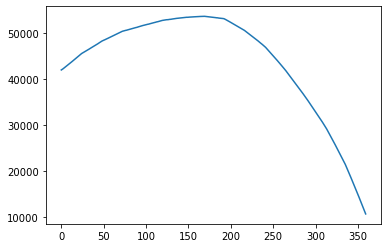

In [65]:
import matplotlib.pyplot as plt
plt.plot(cumList)
plt.show()

In [35]:
grad = graduateAmount(myPayments=myPayments)
print(grad)

2014-09-25 00:00:00 0.055
2014-09-26 00:00:00 0.055
2014-09-27 00:00:00 0.055
2014-09-28 00:00:00 0.055
2014-09-29 00:00:00 0.055
2014-09-30 00:00:00 0.055
2014-10-01 00:00:00 0.055
2014-10-02 00:00:00 0.055
2014-10-03 00:00:00 0.055
2014-10-04 00:00:00 0.055
2014-10-05 00:00:00 0.055
2014-10-06 00:00:00 0.055
2014-10-07 00:00:00 0.055
2014-10-08 00:00:00 0.055
2014-10-09 00:00:00 0.055
2014-10-10 00:00:00 0.055
2014-10-11 00:00:00 0.055
2014-10-12 00:00:00 0.055
2014-10-13 00:00:00 0.055
2014-10-14 00:00:00 0.055
2014-10-15 00:00:00 0.055
2014-10-16 00:00:00 0.055
2014-10-17 00:00:00 0.055
2014-10-18 00:00:00 0.055
2014-10-19 00:00:00 0.055
2014-10-20 00:00:00 0.055
2014-10-21 00:00:00 0.055
2014-10-22 00:00:00 0.055
2014-10-23 00:00:00 0.055
2014-10-24 00:00:00 0.055
2014-10-25 00:00:00 0.055
2014-10-26 00:00:00 0.055
2014-10-27 00:00:00 0.055
2014-10-28 00:00:00 0.055
2014-10-29 00:00:00 0.055
2014-10-30 00:00:00 0.055
2014-10-31 00:00:00 0.055
2014-11-01 00:00:00 0.055
2014-11-02 0

2016-01-13 00:00:00 0.039
2016-01-14 00:00:00 0.039
2016-01-15 00:00:00 0.039
2016-01-16 00:00:00 0.039
2016-01-17 00:00:00 0.039
2016-01-18 00:00:00 0.039
2016-01-19 00:00:00 0.039
2016-01-20 00:00:00 0.039
2016-01-21 00:00:00 0.039
2016-01-22 00:00:00 0.039
2016-01-23 00:00:00 0.039
2016-01-24 00:00:00 0.039
2016-01-25 00:00:00 0.039
2016-01-26 00:00:00 0.039
2016-01-27 00:00:00 0.039
2016-01-28 00:00:00 0.039
2016-01-29 00:00:00 0.039
2016-01-30 00:00:00 0.039
2016-01-31 00:00:00 0.039
2016-02-01 00:00:00 0.039
2016-02-02 00:00:00 0.039
2016-02-03 00:00:00 0.039
2016-02-04 00:00:00 0.039
2016-02-05 00:00:00 0.039
2016-02-06 00:00:00 0.039
2016-02-07 00:00:00 0.039
2016-02-08 00:00:00 0.039
2016-02-09 00:00:00 0.039
2016-02-10 00:00:00 0.039
2016-02-11 00:00:00 0.039
2016-02-12 00:00:00 0.039
2016-02-13 00:00:00 0.039
2016-02-14 00:00:00 0.039
2016-02-15 00:00:00 0.039
2016-02-16 00:00:00 0.039
2016-02-17 00:00:00 0.039
2016-02-18 00:00:00 0.039
2016-02-19 00:00:00 0.039
2016-02-20 0

2017-03-11 00:00:00 0.046
2017-03-12 00:00:00 0.046
2017-03-13 00:00:00 0.046
2017-03-14 00:00:00 0.046
2017-03-15 00:00:00 0.046
2017-03-16 00:00:00 0.046
2017-03-17 00:00:00 0.046
2017-03-18 00:00:00 0.046
2017-03-19 00:00:00 0.046
2017-03-20 00:00:00 0.046
2017-03-21 00:00:00 0.046
2017-03-22 00:00:00 0.046
2017-03-23 00:00:00 0.046
2017-03-24 00:00:00 0.046
2017-03-25 00:00:00 0.046
2017-03-26 00:00:00 0.046
2017-03-27 00:00:00 0.046
2017-03-28 00:00:00 0.046
2017-03-29 00:00:00 0.046
2017-03-30 00:00:00 0.046
2017-03-31 00:00:00 0.046
2017-04-01 00:00:00 0.046
2017-04-02 00:00:00 0.046
2017-04-03 00:00:00 0.046
2017-04-04 00:00:00 0.046
2017-04-05 00:00:00 0.046
2017-04-06 00:00:00 0.046
2017-04-07 00:00:00 0.046
2017-04-08 00:00:00 0.046
2017-04-09 00:00:00 0.046
2017-04-10 00:00:00 0.046
2017-04-11 00:00:00 0.046
2017-04-12 00:00:00 0.046
2017-04-13 00:00:00 0.046
2017-04-14 00:00:00 0.046
2017-04-15 00:00:00 0.046
2017-04-16 00:00:00 0.046
2017-04-17 00:00:00 0.046
2017-04-18 0

In [17]:
from pandas.tseries.offsets import BMonthEnd
from datetime import date

d = pd.Timestamp("2020-05-29")
offset = BMonthEnd()

#Last day of current month
x = offset.rollforward(d)

In [19]:
x

Timestamp('2020-05-29 00:00:00')

In [18]:
d.month == x.month

True

In [ ]:
start = pd.Timestamp("2020-03-31")
end = pd.Timestamp("2020-01-03")
(start - end).days/4

In [15]:
b = 4
print(a)
print(b)

3
4


In [33]:
## build this dictionary from a table which is read in as a csv - potentially even scrape from the student finance website

historicInterest = {"2012": {"start": date(2012, 9, 1), "end": date(2013, 8, 31), "rate": 0.066}, 
                    "2013": {"start": date(2013, 9, 1), "end": date(2014, 8, 31), "rate": 0.063}, 
                    "2014": {"start": date(2014, 9, 1), "end": date(2015, 8, 31), "rate": 0.055}, 
                    "2015": {"start": date(2015, 9, 1), "end": date(2016, 8, 31), "rate": 0.039}, 
                    "2016": {"start": date(2016, 9, 1), "end": date(2017, 8, 31), "rate": 0.046}, 
                    "2017": {"start": date(2017, 9, 1), "end": date(2018, 8, 31), "rate": 0.0618}, 
                    "2018": {"start": date(2018, 9, 1), "end": date(2019, 8, 31), "rate": 0.063}
                   }

In [28]:

current_wd = os.getcwd()
file_name = "trimmed_data.csv"



In [31]:
myPayments = readPayments(file_name)

In [15]:
myPayments = populateInterestRate(myPayments)
myPayments.head()

,PaymentDate,Instalment,Gross,interestRate,totalPayment,cumulativeTotal
0,2014-09-25,1,1191.3,0.055,1256.8215,1256.8215
1,2014-10-15,1,2250.0,0.055,2373.7500,2373.7500
2,2015-01-05,2,1191.3,0.055,1256.8215,1256.8215
3,2015-02-04,2,2250.0,0.055,2373.7500,2373.7500
4,2015-04-20,3,1227.4,0.055,1294.9070,1294.9070


In [250]:
sdate = historicInterest["2017"]["start"]
edate = date(2018,3,31)
interestRate = historicInterest["2017"]["rate"]
interestRate = 0.061
print(interestRate)
cumulativeTotal = graduateAmount
while sdate <= edate:
    print(sdate)
    cumulativeTotal *= (1+(interestRate/365))
    sdate += delta  
cumulativeTotal

0.061
2017-09-01
2017-09-02
2017-09-03
2017-09-04
2017-09-05
2017-09-06
2017-09-07
2017-09-08
2017-09-09
2017-09-10
2017-09-11
2017-09-12
2017-09-13
2017-09-14
2017-09-15
2017-09-16
2017-09-17
2017-09-18
2017-09-19
2017-09-20
2017-09-21
2017-09-22
2017-09-23
2017-09-24
2017-09-25
2017-09-26
2017-09-27
2017-09-28
2017-09-29
2017-09-30
2017-10-01
2017-10-02
2017-10-03
2017-10-04
2017-10-05
2017-10-06
2017-10-07
2017-10-08
2017-10-09
2017-10-10
2017-10-11
2017-10-12
2017-10-13
2017-10-14
2017-10-15
2017-10-16
2017-10-17
2017-10-18
2017-10-19
2017-10-20
2017-10-21
2017-10-22
2017-10-23
2017-10-24
2017-10-25
2017-10-26
2017-10-27
2017-10-28
2017-10-29
2017-10-30
2017-10-31
2017-11-01
2017-11-02
2017-11-03
2017-11-04
2017-11-05
2017-11-06
2017-11-07
2017-11-08
2017-11-09
2017-11-10
2017-11-11
2017-11-12
2017-11-13
2017-11-14
2017-11-15
2017-11-16
2017-11-17
2017-11-18
2017-11-19
2017-11-20
2017-11-21
2017-11-22
2017-11-23
2017-11-24
2017-11-25
2017-11-26
2017-11-27
2017-11-28
2017-11-29
2017

42129.901114597546